<a href="https://colab.research.google.com/github/JanSchering/Thesis/blob/main/ABC_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title install dependencies
!pip install tqdm

Import modules

In [1]:
# @title imports
from typing import Callable, List, Tuple
import torch as t
from torch.distributions import normal, uniform
from helpers import gaussian_pdf
from abc_rej import abc_rej
from abc_mcmc import abc_mcmc
from abc_prc import abc_prc
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# [Approximate Bayesian Computation](https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104)

**Given:**

- Set of observations $x \in \mathcal{X}$, generated by a Data generating Process
- The process can be described via a parametric likelihood with a probability density function (PDF) $f(x|\theta)$, $\theta \in \mathcal{R}^d$
- A prior probability distribution over $\theta$: $\pi(\theta)$

**Goal:**

Describe/Approximate the posterior distribution:

$$
\pi(\theta|x) = \frac{f(x|\theta)\pi(\theta)}{\int_{\theta \in \mathcal{R}^d} f(x|\theta)\pi(\theta)d\theta} \tag{1}
$$

⟹ If the likelihood function is not known or intractable, we cannot sample from (1) efficiently or at all. Instead, we want to draw samples from a sufficiently good approximation of (1). We can obtain these samples via *Approximate Bayesian Computation (ABC)*.

## Defining a toy example

Let the desired posterior be defined by the likelihood function:

$$
f(\theta|x_0) = \frac{1}{2} \phi(0,\frac{1}{100}) + \frac{1}{2}\phi(0,1)
$$

where $\phi(\mu,\sigma^2)$ is the density function of a normal distribution $N(\mu,\sigma^2)$. We define the prior $\pi(\theta)=U(-10,10)$. Further, let $\epsilon=0.025$ and the distance function be defined as:

$$
\rho(x_{sim}, x_{obs}) = 
\begin{cases}
  |\bar{x}| \text{with probability} \frac{1}{2}, \\
  |x_1| \text{with probability} \frac{1}{2} 
\end{cases}
$$

$x^*$ is generated by a normal distribution parameterized by the candidate $\theta^*$:

$$
x^* \sim \mathcal{N}(\theta^*,1)
$$


Define and visualize the posterior we try to approximate as a reference:

(-4.0, 4.0)

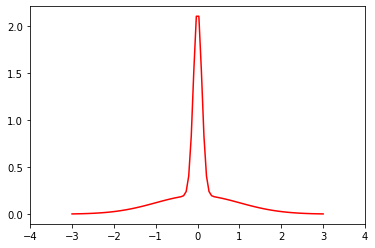

In [2]:
pdf_1 = gaussian_pdf(t.tensor(0), t.tensor(1 / 100))
pdf_2 = gaussian_pdf(t.tensor(0), t.tensor(1))

def posterior(theta: t.Tensor) -> t.Tensor:
    return (1 / 2) * pdf_1(theta) + (1 / 2) * pdf_2(theta)

thetas = t.linspace(-3, 3, 100)

plt.plot(thetas, [posterior(theta) for theta in thetas], color="red")
plt.xlim(-4, 4)

Define the distance function:

In [3]:
def distance_func(X: t.Tensor, Y_sim: t.Tensor, Y_obs: t.Tensor) -> t.Tensor:
    """
    Distance between two datasets <Y_sim> and <Y_obs> as described in
    https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104.
    """
    if random.random() > 0.5:
        return t.abs(t.mean(Y_sim))
    else:
        return t.abs(Y_sim[0])


Define the prior:

In [4]:
# The paper defines a uniform prior U(-10,10)
prior = uniform.Uniform(t.tensor([-10.0]), t.tensor([10.0]))

Define the model:

In [5]:
# according to the paper, the dataset should be 100 samples drawn from N(theta,1)
def model(X: t.Tensor, theta: t.Tensor) -> t.Tensor:
    n = normal.Normal(theta, 1)
    return n.sample_n(100)

## ABC-REJ: Approximate Bayesian computation via rejection sampling

1. Generate $\theta^* \sim \pi(\theta)$
2. Generate $x^* \sim f(x|\theta^*)$
3. Accept $\theta^*$ if $\rho(S(x^*), S(x)) <= \epsilon$, S(.) being the summary statistics of the dataset.
4. If rejected, return to 1.

⟶ Each accepted vector $\theta^*$ is an independent sample drawn from $f(\theta|\rho(S(x), S(x_0)) \leq \epsilon)$. If the statistics $S$ are near-sufficient and $\epsilon$ sufficiently small, $f(\theta|\rho(S(x), S(x_0)) \leq \epsilon)$ becomes a reasonable approximation of the posterior.

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:48<00:00, 20.53it/s]

average # steps for acceptance: 388.289


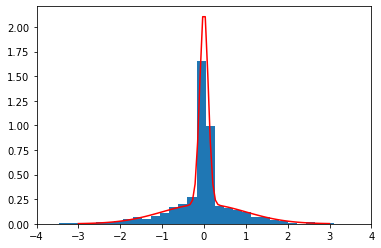

In [6]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}
epsilon = 0.025
samples = []
required_steps = []

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
    sample, num_steps = abc_rej(None, None, epsilon, prior.sample, model, distance_func)
    samples.append(sample)
    required_steps.append(num_steps)

print(f"average # steps for acceptance: {np.mean(required_steps)}")

plt.hist(t.tensor(samples), density=True, bins=30)
theta_refs = t.linspace(-3, 3, 100)
plt.plot(theta_refs, [posterior(theta) for theta in theta_refs], color="red")
plt.xlim(-4, 4)
plt.show()


## ABC-MCMC: Approximate Bayesian computation via Markov-Chain Monte-Carlo

1. Initialize $\theta_1, i=1$
2. Generate $\theta^* \sim q(\theta|\theta_i)$, from an arbitrary proposal density $q$
3. Generate $x^* \sim f(x|\theta^*)$
4. Set $\theta_{i+1}=\theta^*$ with the following probability:

$$
\alpha = \min \begin{cases} 1, \frac{\pi(\theta^*)q(\theta_i|\theta^*)}{\pi(\theta_i)q(\theta^*|\theta_i)} \textbf{1}(\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon) \end{cases}
$$

Set $\theta_{i+1}=\theta_{i}$ otherwise.

Here, $\textbf{1}(A)$ is true if the statement $A$ evaluates to $True$, 0 otherwise.

Define $q(\theta|\theta_i) = q(\theta_i, \sigma)$ with $\sigma = 0.1$ and a PDF for the uniform prior distribution:

In [12]:
sigma = t.tensor(0.15)

def q(theta: t.Tensor):
    return normal.Normal(theta, sigma).sample()

def gauss_likelihood(x: t.Tensor, y: t.Tensor) -> float:
    pdf = gaussian_pdf(y, sigma**2)
    return pdf(x)

def uniform_likelihood(low: float, high: float, x: t.Tensor) -> float:
    if x > high or x < low:
        return 0
    else:
        return 1 / (high - low)


Define a function for the (Metropolis-Hastings) acceptance rate:

In [8]:
def calc_alpha(
    theta_star: t.Tensor, theta: t.Tensor, epsilon: float, dist: t.Tensor
) -> t.Tensor:
    if dist <= epsilon and uniform_likelihood(-10, 10, theta_star) > 0:
        ratio = gauss_likelihood(theta, theta_star) / gauss_likelihood(
            theta_star, theta
        )
        return t.min(t.tensor([t.tensor(1.0), ratio]))
    else:
        return t.tensor(0.0)

Run the algorithm:

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 10000/10000 [00:02<00:00, 4413.51it/s]



 accepted 307 samples


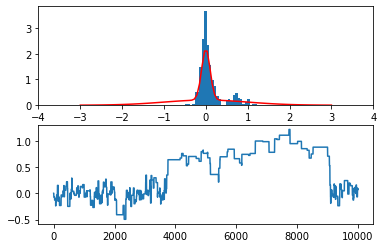

In [26]:
N = 10_000
epsilon = 0.025
theta_init = t.tensor(0.0)

samples, sample_hist, step_hist = abc_mcmc(None, None, theta_init, model, distance_func, calc_alpha, epsilon, q, N)

print(f"\n accepted {len(samples)} samples")

fig, axs = plt.subplots(2)
axs[0].hist(samples, density=True, bins=30)
test_vals = t.linspace(-3, 3, 100)
axs[0].plot(test_vals, [posterior(test_val) for test_val in test_vals], color="red")
axs[1].plot(np.arange(len(sample_hist)), sample_hist)
axs.flat[0].set_xlim(-4, 4)
plt.show()

## ABC-PRC: Approximate Bayesian computation via Sequential Monte-Carlo with Particle Rejection Control

**Goal:**

Draw $N$ samples (particles) from the posterior distribution $f(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon)$.

**Given:**

- Summary statistics $S(.)$
- Threshold $\epsilon$
- Distance Function $\rho$ 

**Approach:**

1. Define an initial population $\theta^{(1)}, \dots, \theta^{(N)} \sim \mu_1$, with $\mu_1$ being a known distribution we can sample from
2. Define $f_T(\theta) = f(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon)$

→ Standard Importance Sampling: Weigh all drawn particles by their importance $W^{(i)}_T = f_T(\theta^{(i)}_1)/\mu_1(\theta^{(i)}_1)$.

****

**Problem 1:** Can fail or become inefficient if there is a mismatch between sampling distribution $\mu_1$ and target distribution $f_T$ 

⟶ Solution (Sequential Sampling): Define a sequence of intermediary distributions $f_1, \dots, f_{T-1}$, gradually moving from $\mu_1$ towards $f_T$. Then iteratively move and reweight the particles in accordance to their adherence to each consecutive distribution $f_t,$ for $t=1,\dots,T$.

In the case of ABC, the sequence of distributions can be defined as:

$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$

with:

- $x_{(1)},\dots, x_{(B_t)}$ being $B_T$ datasets generated with a fixed parameter vector $\theta$, $x_{(b)} \sim f(x|\theta)$
- $\{\epsilon_t\}$ being a strictly decreasing sequence of thresholds

****

**Problem 2:** With this method, the particle weights are directly proportional to the likelihood of the particles. There is a high probability that this likelihood equates to 0. A zero-likelihood means zero weight, which makes the particle useless as it is out of consideration.

⟶ Solution (Particle Rejection Control): Using PRC, we can resample from the previous distribution and move the sampled particles, in order to get a replacement for those particles with zero-weight. We do this replacement step until we have a population of $N$ particles with non-zero weight.

****

**ABC-PRC Algorithm:**

1. Define
  - $\epsilon_1, \dots, \epsilon_T$ 
  - sampling distribution $\mu_1$
  - population indicator $t=1$
2. Set particle indicator $i=1$, then
  1. IF
  - $t == 1$: sample $\theta^{**} \sim \mu_1(\theta)$ independently 
  - $t > 1$: sample $\theta^{*}$ from the prev. population, weighted by their importance $W^{(i)}_{t-1}$, then move the particle to $\theta^{**} \sim K_t(\theta|\theta^*)$ according to a Markov transition kernel $K_t$
  2. Sample $x^{**} \sim f(x|\theta^{**})$
  3. IF $\rho(S(x^{**}), S(x_{obs})) \geq \epsilon_t$, go back to 2.1
  4. Set 
$$
\theta^{(i)}_t = \theta^{**}, W^{(i)}_t = 
\begin{cases}
\pi(\theta^{(i)}_t)/\mu_1(\theta^{(i)}_t) \text{if t==1}, \\
\frac{\pi(\theta^{(i)}_t)L_{t-1}(\theta^*|\theta^{(i)}_t)}{\pi(\theta^*)K_t(\theta^{(i)}_t|\theta^*)} \text{if t>1}
\end{cases}
$$
with $\pi(\theta)$ being the prior distribution and $L_{t-1}$ a backward transition kernel
  5. IF $i < N$, increment $i = i + 1$ then return to 2.1
3. Normalize the weights, such that $\sum_{i=1}^N W^{(i)}_t = 1$
4. Calculate $ESS = [\sum_{i=1}^N (W^{(i)}_t)^2]^{-1}$. IF $ESS < E$, resample the particles $\{\theta^{(i)}_t\}$ with current weights $\{W^{(i)}_t\}$ to get a new population of particles $\{\theta^{(i)}_t\}$. Set the weights of the new population to $\{W^{(i)}_t = 1/N \}$.
5. IF $t < T$, increment $t=t+1$ and return to 2.

NOTE: If $T=1$ and $\mu_1(\theta)=\pi(\theta)$, ABC-PRC is equivalent to ABC-REJ.

****

**Implementation Notes from the paper:**

- In the examples, $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$ as a gaussian kernel with common variance
- From $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, $\mu_1(\theta)=\pi(\theta)$, $\pi(\theta) \propto 1$ over the parameters space $\Theta$, follows that all weights are equal during sampling and can be ignored. This also means that for this special case steps 3. and 4. can be ignored

define Kernel $K_t(\theta_t|\theta_{t-1}) = \mathcal{N}(\theta_{t-1}, 1)$

In [6]:
def kernel(theta: t.tensor) -> t.Tensor:
    return normal.Normal(theta, t.tensor(1.0)).sample()

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 3/3 [00:13<00:00,  4.38s/it]


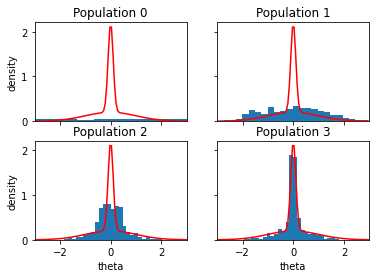

In [7]:
N = 1000
epsilons = [2, 0.5, 0.025]
mu_1 = uniform.Uniform(t.tensor(-10.0), t.tensor(10.0)).sample_n

thetas, theta_hist = abc_prc(
    None, None, model, mu_1, kernel, distance_func, epsilons, N
)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
test_vals = t.linspace(-3, 3, 100)

axs[0, 0].hist(theta_hist[0], density=True, bins=30)
axs[0, 0].set(ylabel="density", title="Population 0")
axs[0, 0].plot(test_vals, [posterior(test_val) for test_val in test_vals], color="red")
axs[0, 1].hist(theta_hist[1], density=True, bins=30)
axs[0, 1].set(title="Population 1")
axs[0, 1].plot(test_vals, [posterior(test_val) for test_val in test_vals], color="red")
axs[1, 0].hist(theta_hist[2], density=True, bins=30)
axs[1, 0].set(xlabel="theta", ylabel="density", title="Population 2")
axs[1, 0].plot(test_vals, [posterior(test_val) for test_val in test_vals], color="red")
axs[1, 1].hist(theta_hist[3], density=True, bins=30)
axs[1, 1].set(xlabel="theta", title="Population 3")
axs[1, 1].plot(test_vals, [posterior(test_val) for test_val in test_vals], color="red")

plt.xlim(-3, 3)
plt.show()